In [15]:
import pandas as pd
import torch
import torch.nn as nn
import torchtext
import torchtext.vocab as vocab
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np

In [2]:
#seed random number generator
torch.manual_seed(0)

In [3]:
device = torch.device("mps")

In [4]:
# Prepare the dataset
# Read the CSV file
data = pd.read_csv('data.csv')

# Splitting data into features and labels
X = data['tweet'].values

# Splitting the dataset into training and validation sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Creating DataFrame for training and validation sets
train_data = pd.DataFrame({'tweet': X_train})
test_data = pd.DataFrame({'tweet': X_test})

In [5]:
train_data

,tweet
0,RT @FunSizedYogi: @TheBlackVoice well how else...
1,Funny thing is....it's not just the people doi...
2,"RT @winkSOSA: ""@AintShitSweet__: ""@Rakwon_OGOD..."
3,@Jbrendaro30 @ZGabrail @ramsin1995 @GabeEli8 @...
4,S/o that real bitch
...,...
19821,The last at-bat at Yankee Stadium. Thanks for ...
19822,@_bradleey LMFAOOOO yooo I lost my elevator pa...
19823,"#porn,#android,#iphone,#ipad,#sex,#xxx, | #Ana..."
19824,RT @JennyJohnsonHi5: Just when I thought Justi...


In [6]:
test_data

,tweet
0,934 8616\ni got a missed call from yo bitch
1,RT @KINGTUNCHI_: Fucking with a bad bitch you ...
2,RT @eanahS__: @1inkkofrosess lol my credit ain...
3,RT @Maxin_Betha Wipe the cum out of them faggo...
4,Niggas cheat on they bitch and don't expect no...
...,...
4952,@GrizzboAdams @wyattnuckels haha ight nig calm...
4953,When you see kids being bad &amp; their parent...
4954,This bitch done blew my high
4955,Fat Trel that niggah &#128076;


In [7]:
# Target Model

# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
# model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
# # This one said non-hate to a lot of hate speech as far as I have tried.

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
target_model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english").to(device)

In [8]:
# For validation w.r.t. the target model (but does it technically increases the number of queries?)
def get_label(input_text):
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # Query the target model
    with torch.no_grad():
        target_outputs = target_model(**inputs)

    target_labels = target_outputs.logits.softmax(dim=1).tolist()[0]
    return target_labels

test_data['label'] = test_data['tweet'].apply(get_label) # ~ 2/3 mins
test_data

,tweet,label
0,934 8616\ni got a missed call from yo bitch,"[0.5540308952331543, 0.4459691643714905]"
1,RT @KINGTUNCHI_: Fucking with a bad bitch you ...,"[0.3774803876876831, 0.6225196719169617]"
2,RT @eanahS__: @1inkkofrosess lol my credit ain...,"[0.9582732319831848, 0.04172678291797638]"
3,RT @Maxin_Betha Wipe the cum out of them faggo...,"[0.09527343511581421, 0.904726505279541]"
4,Niggas cheat on they bitch and don't expect no...,"[0.11824338138103485, 0.881756603717804]"
...,...,...
4952,@GrizzboAdams @wyattnuckels haha ight nig calm...,"[0.09661741554737091, 0.9033825397491455]"
4953,When you see kids being bad &amp; their parent...,"[0.35169070959091187, 0.6483092904090881]"
4954,This bitch done blew my high,"[0.21178992092609406, 0.7882100939750671]"
4955,Fat Trel that niggah &#128076;,"[0.08707571029663086, 0.9129242300987244]"


In [9]:
# Pre-trained embeddings
# Load pre-trained GloVe embeddings
embed_dim = 100
glove = vocab.GloVe(name='6B', dim=embed_dim)

# Get the vocabulary from the pre-trained embeddings
glove_vocab = glove.stoi  # Dictionary mapping words to their indices

In [10]:
# Clone Model class
class HateSpeechGRU(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_size, output_dim, dropout):
        super(HateSpeechGRU, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_dim)  # * 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)  # text: [batch size, sent len]
        output, hidden = self.gru(embedded)  # output: [batch size, sent len, hidden_size * num_directions]
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  # concatenate the final forward and backward hidden states
        hidden = self.dropout(hidden)
        output = self.fc(hidden)  # output: [batch size, output dim]
        return output

In [12]:
# Clone Model
# Define hyperparameters
pretrained_embeddings = glove.vectors
hidden_size = 128  # Size of hidden states in the GRU
output_dim = 2  # Number of output classes (binary classification)
dropout = 0.5  # Dropout probability

clone_model = HateSpeechGRU(pretrained_embeddings, hidden_size, output_dim, dropout).to(device)

In [13]:
# Load pre-trained Sentence Transformer model
sent_transformer = SentenceTransformer("all-MiniLM-L6-v2").to(device)

# Create the embeddings for the training data
# ~ 30 secs
train_embeddings = sent_transformer.encode(train_data['tweet'].tolist(), convert_to_tensor=True).tolist()

#normalize the embeddings
train_embeddings = torch.tensor(train_embeddings).to(device)
print(train_embeddings.shape)
train_embeddings = nn.functional.normalize(train_embeddings, p=2, dim=1)
print(train_embeddings.shape)

train_data['embedding'] = train_embeddings.cpu().tolist()
train_data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


torch.Size([19826, 384])
torch.Size([19826, 384])


,tweet,embedding
0,RT @FunSizedYogi: @TheBlackVoice well how else...,"[-0.04517171159386635, 0.13797102868556976, 0...."
1,Funny thing is....it's not just the people doi...,"[0.050247207283973694, 0.0015786909498274326, ..."
2,"RT @winkSOSA: ""@AintShitSweet__: ""@Rakwon_OGOD...","[-0.11634157598018646, 0.04812648147344589, 0...."
3,@Jbrendaro30 @ZGabrail @ramsin1995 @GabeEli8 @...,"[-0.15736792981624603, -0.020282931625843048, ..."
4,S/o that real bitch,"[-0.11650454998016357, -0.026171348989009857, ..."
...,...,...
19821,The last at-bat at Yankee Stadium. Thanks for ...,"[-0.027169303968548775, 0.11435810476541519, 0..."
19822,@_bradleey LMFAOOOO yooo I lost my elevator pa...,"[-0.0282177422195673, -0.054308995604515076, 0..."
19823,"#porn,#android,#iphone,#ipad,#sex,#xxx, | #Ana...","[0.0208604633808136, -0.0533132366836071, 0.01..."
19824,RT @JennyJohnsonHi5: Just when I thought Justi...,"[0.009069043211638927, -0.011038385331630707, ..."


In [16]:
# Table to store the previous queries (for wise query selection later)
table = pd.DataFrame({
    'tweet': [],
    'embedding': [],
    't_out': [],
    'c_out': [],
    'count': []
})

alpha = 0.7
initial_alpha = alpha
final_alpha = 0.4
decay_rate = np.log(final_alpha / initial_alpha) / 100  # Calculate decay rate to reach final_alpha in 100 iterations

# Initial weight for the 'similarity with the previous queries that had high disagreement' term
beta = 1 - alpha#

# Train the clone model
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.SGD(clone_model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(clone_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # Decay LR by 0.99 each epoch


batch_size = 128

# Define number of epochs
epoch = 0

loss_vals = []
best_loss = float('inf')

scaler = GradScaler()

repeated_counts = []

# Training loop

while True:
    clone_model.train()

    if table.shape[0] == 0: # Cold start for the first query (can be random)
        idxs = torch.randperm(len(train_data))[:batch_size].tolist()
    else:
        # Wise query selection
        # Calculate the cosine similarity between the embeddings of the training data and the table
        similarities = util.cos_sim(torch.tensor(train_data['embedding'].tolist()), torch.tensor(table['embedding'].tolist()))

        # Calculate the average cosine similarity for each training data
        # 'dissimilariy with the previous queries'
        avg_similarities = similarities.max(dim=1).values

        # 'similarity with the previous queries that had hish disagreement'
        disagreement = torch.tensor((abs(table['c_out'] - table['t_out'])).tolist())

        similarities = similarities * disagreement
        avg_wrt_disagreement = similarities.mean(dim=1)

        # Calculating Z-scores for avg_similarities and avg_wrt_disagreement
        avg_similarities_z = (avg_similarities - avg_similarities.mean()) / avg_similarities.std()
        avg_wrt_disagreement_z = (avg_wrt_disagreement - avg_wrt_disagreement.mean()) / avg_wrt_disagreement.std()

        # Calculate the normalized formula for each training data
        formula = alpha * (-avg_similarities_z) + beta * avg_wrt_disagreement_z

        # Get the index of the training data with the lowest average cosine similarity
        idxs = formula.argsort(descending=True)[:batch_size].tolist()

        #print('argsorted formula', formula.sort(descending=True)[:batch_size])

    input_texts = train_data.iloc[idxs]['tweet']

    # Check if the input_texts are already queried
    will_added = [True] * len(input_texts)

    count = 0
    for t in range(len(input_texts)):
        if input_texts.iloc[t] in table['tweet'].tolist():
            will_added[t] = False
            count += 1
            table.loc[table['tweet'] == input_texts.iloc[t], 'count'] += 1
    print('girdigi sayi', count)
    repeated_counts.append(count)


    input_embeds = train_data.iloc[idxs]['embedding']

    # inputs = tokenizer(input_text, return_tensors="pt")
    input_tokens = tokenizer(input_texts.tolist(), return_tensors="pt", padding=True, truncation=False).to(device)

    # Query the target model
    with torch.no_grad():
        target_outputs = target_model(**input_tokens)

    target_labels = target_outputs.logits.softmax(dim=1).tolist()

    # Conver input_text to tensor using glove_vocab
    input_glove = [[glove_vocab[word] if word in glove_vocab else glove_vocab['unk'] for word in input_text.split()] for input_text in input_texts]
    max_len = max([len(input_text) for input_text in input_glove])
    input_glove = [input_text + [glove_vocab['unk']] * (max_len - len(input_text)) for input_text in input_glove]
    input_glove = torch.tensor(input_glove, dtype=torch.long).to(device)

    target_outputs = torch.tensor(target_labels).to(device)

    # Forward pass through the clone model
    with autocast():
        clone_logits = clone_model(input_glove)
        clone_outputs = torch.softmax(clone_logits, dim=-1)
        loss = criterion(clone_outputs, target_outputs)

    optimizer.zero_grad()

    scaler.scale(loss).backward()

    # Update model weights considering the scaled gradients
    scaler.step(optimizer)

    # Updates the scale for next iteration
    scaler.update()
    scheduler.step()  # Update learning rate decay

    #update alpha and beta values
    alpha = initial_alpha * np.exp(decay_rate * epoch)
    beta = 1 - alpha

    input_texts = input_texts[will_added]
    input_embeds = input_embeds[will_added]
    target_outputs = target_outputs[will_added]
    clone_outputs = clone_outputs[will_added]

    # Add row to table
    row = pd.DataFrame({'tweet': input_texts, 'embedding': input_embeds, 't_out': target_outputs[:,0].tolist(), 'c_out': clone_outputs[:,0].tolist(), 'count': [1] * sum(will_added)})
    table = pd.concat([table, row], ignore_index=True)

    # Evaluation
    clone_model.eval()

    with torch.inference_mode():

        # Updating the table
        input_glove_2 = [[glove_vocab[word] if word in glove_vocab else glove_vocab['unk'] for word in input_text.split()] for input_text in table['tweet'].tolist()]
        max_len = max([len(input_text) for input_text in input_glove_2])
        input_glove_2 = [input_text + [glove_vocab['unk']] * (max_len - len(input_text)) for input_text in input_glove_2]

        input_glove_2 = torch.tensor(input_glove_2, dtype=torch.long).to(device)

        with autocast():
            clone_logits_2 = clone_model(input_glove_2)
            clone_outputs_2 = torch.softmax(clone_logits_2, dim=-1)

        table['c_out'] = clone_outputs_2[:,0].tolist()

        # Validation set
        inputs = [[glove_vocab[word] if word in glove_vocab else glove_vocab['unk'] for word in txt.split()] for txt in test_data['tweet'].tolist()] # TODO: Do once, don't do it in every epoch
        max_len = max([len(txt) for txt in inputs])
        inputs = [txt + [glove_vocab['unk']] * (max_len - len(txt)) for txt in inputs]


        test_pred = clone_model(torch.tensor(inputs, device=device))
        test_loss = criterion(test_pred, torch.tensor(test_data['label'].tolist(), device=device))

    loss_val = test_loss.item()
    loss_vals.append(loss_val)
    print(f'Epoch [{epoch + 1}], Loss: {loss_val}')
    loss_vals.append(loss_val)

    # Check if this is the best loss we've seen
    if loss_val < best_loss:
        best_loss = loss_val
        best_model_weights = clone_model.state_dict()
        best_table = table.copy()

    epoch += 1

    print('table size ' ,table.shape)

/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [1], Loss: 0.6863031983375549
table size  (128, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [2], Loss: 0.6850197911262512
table size  (256, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [3], Loss: 0.6966934204101562
table size  (384, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [4], Loss: 0.7117944955825806
table size  (512, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [5], Loss: 0.7168015241622925
table size  (640, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [6], Loss: 0.7148882746696472
table size  (768, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [7], Loss: 0.7072955369949341
table size  (896, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [8], Loss: 0.6967710256576538
table size  (1024, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [9], Loss: 0.6868205070495605
table size  (1152, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [10], Loss: 0.6806432008743286
table size  (1280, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [11], Loss: 0.6799490451812744
table size  (1408, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [12], Loss: 0.6852908730506897
table size  (1536, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [13], Loss: 0.6949608325958252
table size  (1664, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [14], Loss: 0.7070708870887756
table size  (1792, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [15], Loss: 0.7191318273544312
table size  (1920, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [16], Loss: 0.7314610481262207
table size  (2048, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [17], Loss: 0.7424754500389099
table size  (2176, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [18], Loss: 0.7500373125076294
table size  (2304, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [19], Loss: 0.7545790076255798
table size  (2432, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [20], Loss: 0.7559764981269836
table size  (2560, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [21], Loss: 0.7584258913993835
table size  (2688, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [22], Loss: 0.7555992007255554
table size  (2816, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [23], Loss: 0.7536342740058899
table size  (2944, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [24], Loss: 0.7529130578041077
table size  (3072, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [25], Loss: 0.7552660703659058
table size  (3200, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [26], Loss: 0.7548730373382568
table size  (3328, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [27], Loss: 0.756130576133728
table size  (3456, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [28], Loss: 0.7597166895866394
table size  (3584, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [29], Loss: 0.7645788788795471
table size  (3712, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [30], Loss: 0.7683934569358826
table size  (3840, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [31], Loss: 0.7728211879730225
table size  (3968, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [32], Loss: 0.7776483297348022
table size  (4096, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [33], Loss: 0.7799633741378784
table size  (4224, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [34], Loss: 0.7840261459350586
table size  (4352, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [35], Loss: 0.789980947971344
table size  (4480, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [36], Loss: 0.7938728332519531
table size  (4608, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [37], Loss: 0.7997459769248962
table size  (4736, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [38], Loss: 0.8072597980499268
table size  (4864, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [39], Loss: 0.8157692551612854
table size  (4992, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [40], Loss: 0.8226025104522705
table size  (5120, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [41], Loss: 0.8333490490913391
table size  (5248, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [42], Loss: 0.838787317276001
table size  (5376, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [43], Loss: 0.8419045209884644
table size  (5504, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [44], Loss: 0.8439587354660034
table size  (5632, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [45], Loss: 0.8425180315971375
table size  (5760, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [46], Loss: 0.8362439274787903
table size  (5888, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [47], Loss: 0.8304251432418823
table size  (6016, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [48], Loss: 0.8236382603645325
table size  (6144, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [49], Loss: 0.8158278465270996
table size  (6272, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [50], Loss: 0.8066196441650391
table size  (6400, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [51], Loss: 0.7992285490036011
table size  (6528, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [52], Loss: 0.7888516783714294
table size  (6656, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [53], Loss: 0.7769221663475037
table size  (6784, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [54], Loss: 0.7667340636253357
table size  (6912, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [55], Loss: 0.7588254809379578
table size  (7040, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [56], Loss: 0.7524985671043396
table size  (7168, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [57], Loss: 0.7493597269058228
table size  (7296, 5)
girdigi sayi 0


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [58], Loss: 0.7467673420906067
table size  (7424, 5)
girdigi sayi 1


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [59], Loss: 0.7431738972663879
table size  (7551, 5)
girdigi sayi 3


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [60], Loss: 0.7406674027442932
table size  (7676, 5)
girdigi sayi 4


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [61], Loss: 0.7370005249977112
table size  (7800, 5)
girdigi sayi 4


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [62], Loss: 0.7320113182067871
table size  (7924, 5)
girdigi sayi 6


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [63], Loss: 0.7278400659561157
table size  (8046, 5)
girdigi sayi 11


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [64], Loss: 0.7202579975128174
table size  (8163, 5)
girdigi sayi 14


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [65], Loss: 0.7111788988113403
table size  (8277, 5)
girdigi sayi 21


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [66], Loss: 0.711559534072876
table size  (8384, 5)
girdigi sayi 32


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [67], Loss: 0.7117805480957031
table size  (8480, 5)
girdigi sayi 48


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [68], Loss: 0.7202669978141785
table size  (8560, 5)
girdigi sayi 72


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [69], Loss: 0.7447824478149414
table size  (8616, 5)
girdigi sayi 95


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [70], Loss: 0.7998079657554626
table size  (8649, 5)
girdigi sayi 117


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [71], Loss: 0.9056002497673035
table size  (8660, 5)
girdigi sayi 126


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [72], Loss: 1.0557684898376465
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [73], Loss: 1.2167466878890991
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [74], Loss: 1.3588433265686035
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [75], Loss: 1.4780603647232056
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [76], Loss: 1.5780251026153564
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [77], Loss: 1.6618832349777222
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [78], Loss: 1.7342603206634521
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [79], Loss: 1.7962605953216553
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [80], Loss: 1.84981107711792
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [81], Loss: 1.897322416305542
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [82], Loss: 1.9361233711242676
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [83], Loss: 1.9677625894546509
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [84], Loss: 1.9941620826721191
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [85], Loss: 2.0143911838531494
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [86], Loss: 2.0287699699401855
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [87], Loss: 2.0376291275024414
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [88], Loss: 2.0424349308013916
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [89], Loss: 2.0388429164886475
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [90], Loss: 2.018120765686035
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [91], Loss: 1.9829013347625732
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [92], Loss: 1.9456150531768799
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [93], Loss: 1.909342646598816
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [94], Loss: 1.8751460313796997
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [95], Loss: 1.8414161205291748
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [96], Loss: 1.8063468933105469
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [97], Loss: 1.7686048746109009
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [98], Loss: 1.7254399061203003
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [99], Loss: 1.6723604202270508
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [100], Loss: 1.6040890216827393
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [101], Loss: 1.532221794128418
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [102], Loss: 1.4753719568252563
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [103], Loss: 1.431840419769287
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [104], Loss: 1.4084707498550415
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [105], Loss: 1.401318073272705
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [106], Loss: 1.408370852470398
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [107], Loss: 1.4297161102294922
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [108], Loss: 1.4640417098999023
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [109], Loss: 1.506210207939148
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [110], Loss: 1.5509520769119263
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [111], Loss: 1.5951073169708252
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [112], Loss: 1.6389679908752441
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [113], Loss: 1.6807032823562622
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [114], Loss: 1.7156922817230225
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [115], Loss: 1.7434353828430176
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [116], Loss: 1.7625749111175537
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [117], Loss: 1.7707030773162842
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [118], Loss: 1.7707432508468628
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [119], Loss: 1.7656234502792358
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [120], Loss: 1.7551125288009644
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [121], Loss: 1.7417105436325073
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [122], Loss: 1.7276527881622314
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [123], Loss: 1.7138744592666626
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [124], Loss: 1.7010891437530518
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [125], Loss: 1.692511796951294
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [126], Loss: 1.6909078359603882
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [127], Loss: 1.691990613937378
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [128], Loss: 1.7004978656768799
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [129], Loss: 1.712678074836731
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [130], Loss: 1.7287614345550537
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [131], Loss: 1.7472209930419922
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [132], Loss: 1.7685867547988892
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [133], Loss: 1.7884076833724976
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [134], Loss: 1.8054301738739014
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [135], Loss: 1.8192013502120972
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [136], Loss: 1.8294453620910645
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [137], Loss: 1.835023045539856
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [138], Loss: 1.837019681930542
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [139], Loss: 1.8376946449279785
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [140], Loss: 1.8379507064819336
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [141], Loss: 1.8390202522277832
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [142], Loss: 1.838801383972168
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [143], Loss: 1.8401432037353516
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [144], Loss: 1.8387850522994995
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [145], Loss: 1.8357539176940918
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [146], Loss: 1.8307944536209106
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [147], Loss: 1.8295621871948242
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [148], Loss: 1.831629753112793
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [149], Loss: 1.8346014022827148
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [150], Loss: 1.840402603149414
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [151], Loss: 1.8469208478927612
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [152], Loss: 1.8588807582855225
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [153], Loss: 1.8721331357955933
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [154], Loss: 1.8867112398147583
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [155], Loss: 1.9028985500335693
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [156], Loss: 1.9166873693466187
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [157], Loss: 1.926146149635315
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [158], Loss: 1.933108925819397
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [159], Loss: 1.9352391958236694
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [160], Loss: 1.9342724084854126
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [161], Loss: 1.9306985139846802
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [162], Loss: 1.9272305965423584
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [163], Loss: 1.9268748760223389
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [164], Loss: 1.9280009269714355
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [165], Loss: 1.9295482635498047
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [166], Loss: 1.9337769746780396
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [167], Loss: 1.9389101266860962
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [168], Loss: 1.9465303421020508
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [169], Loss: 1.9545233249664307
table size  (8662, 5)
girdigi sayi 128


/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [170], Loss: 1.9627338647842407
table size  (8662, 5)


KeyboardInterrupt: 

Best Loss: 0.6799490451812744  at iteration:  20


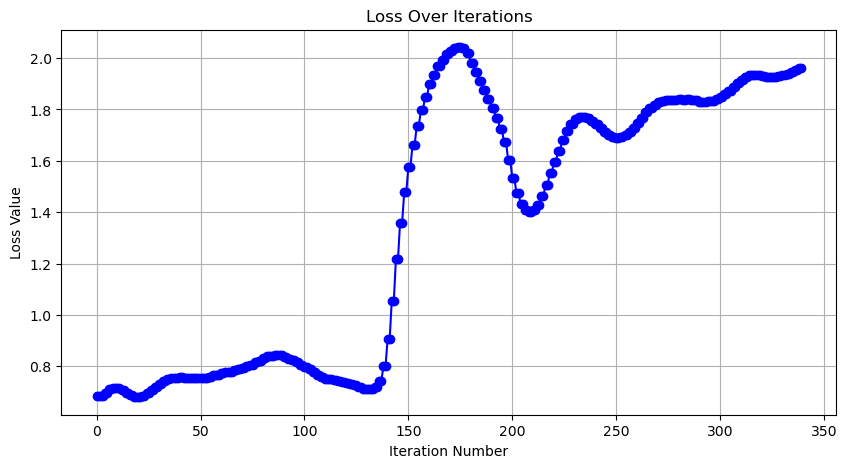

In [17]:
#SGD
print('Best Loss:',best_loss,' at iteration: ', loss_vals.index(best_loss))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_vals, marker='o', linestyle='-', color='b')
plt.title('Loss Over Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

Best Loss: 0.6799490451812744  at iteration:  20


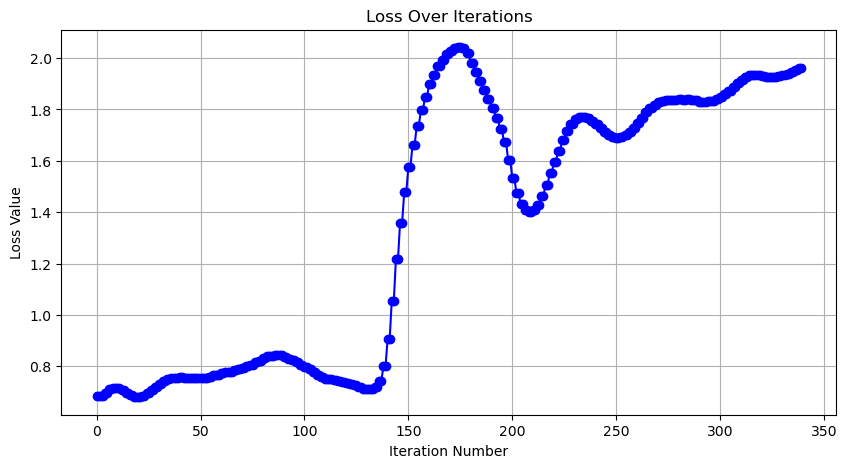

In [18]:
#ADAM
print('Best Loss:',best_loss,' at iteration: ', loss_vals.index(best_loss))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_vals, marker='o', linestyle='-', color='b')
plt.title('Loss Over Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()